In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.optimize import minimize

In [2]:
tickers = ['AAPL', 'MSFT', 'NVDA', 'NFLX', 'GOOGL']
end_date = dt.datetime(2023, 1, 1); start_date = end_date - dt.timedelta(days=4*365)
stock = yf.download(tickers, start=start_date, end=end_date)
stock.head()

C:\Users\sayak\AppData\Local\Temp\ipykernel_10760\2959137352.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed


Price           Close                                                   High  \
Ticker           AAPL      GOOGL       MSFT        NFLX      NVDA       AAPL   
Date                                                                           
2019-01-02  37.617847  52.419621  94.945488  267.660004  3.377545  37.839383   
2019-01-03  33.870834  50.967827  91.452660  271.200012  3.173483  34.711709   
2019-01-04  35.316753  53.582150  95.706070  297.570007  3.376801  35.385836   
2019-01-07  35.238148  53.475292  95.828110  315.339996  3.555572  35.452537   
2019-01-08  35.909897  53.944977  96.522926  320.269989  3.467054  36.164781   

Price                                                   ...       Open  \
Ticker          GOOGL       MSFT        NFLX      NVDA  ...       AAPL   
Date                                                    ...              
2019-01-02  52.723299  95.537017  269.750000  3.433581  ...  36.896077   
2019-01-03  52.995169  94.072300  275.790009  3.351262  ...  34.297226   
2019-01-04  53.678075  96.250656  297.799988  3.414985  ...  34.428238   
2019-01-07  53.812268  96.964225  316.799988  3.592516  ...  35.421569   
2019-01-08  54.341596  97.621483  320.589996  3.639378  ...  35.626428   

Price                                                      Volume            \
Ticker          GOOGL       MSFT        NFLX      NVDA       AAPL     GOOGL   
Date                                                                          
2019-01-02  51.053811  93.471354  259.279999  3.239190  148158800  31868000   
2019-01-03  52.220317  93.987792  270.200012  3.317293  365248800  41960000   
2019-01-04  51.817233  93.631015  281.880005  3.246629  234428400  46022000   
2019-01-07  53.726286  95.433757  302.100006  3.434077  219111200  47446000   
2019-01-08  53.976287  96.748270  319.980011  3.637146  164101200  35414000   

Price                                      
Ticker          MSFT      NFLX       NVDA  
Date                                       
2019-01-02  35329300  11679500  508752000  
2019-01-03  42579100  14969600  705552000  
2019-01-04  44060600  19330100  585620000  
2019-01-07  35656100  18620100  709160000  
2019-01-08  31514400  15359200  786016000  

[5 rows x 25 columns]

Text(0.5, 1.0, 'Normalized Returns of Selected Stocks')

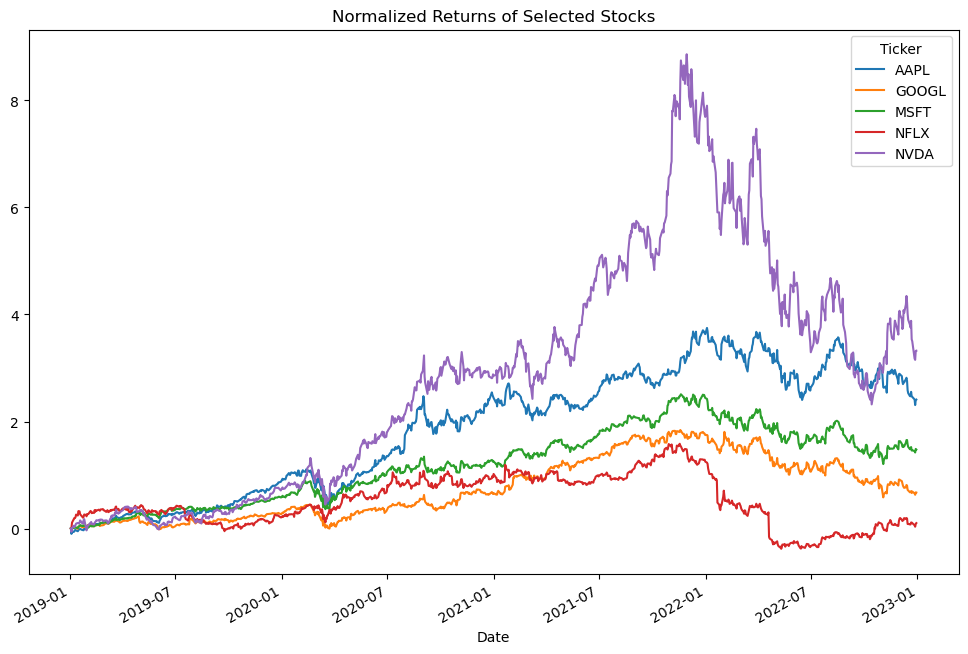

In [3]:
close_prices = stock['Close']
close_prices.head()
normalized_returns = close_prices/close_prices.iloc[0] - 1

normalized_returns.plot(figsize=(12, 8))
plt.title('Normalized Returns of Selected Stocks')

In [4]:
log_returns = np.log(close_prices/close_prices.shift(1))
log_returns.dropna(inplace=True)
log_returns.head()

Ticker,AAPL,GOOGL,MSFT,NFLX,NVDA
Date,,,,,
2019-01-03,-0.104924,-0.028086,-0.037481,0.013139,-0.062319
2019-01-04,0.041803,0.050021,0.045460,0.092793,0.062099
2019-01-07,-0.002228,-0.001996,0.001274,0.058002,0.051587
2019-01-08,0.018884,0.008745,0.007224,0.015513,-0.025211
2019-01-09,0.016839,-0.003433,0.014198,-0.000968,0.019476


Text(0.5, 1.0, 'Estimated Covariance Matrix of Yearly Returns')

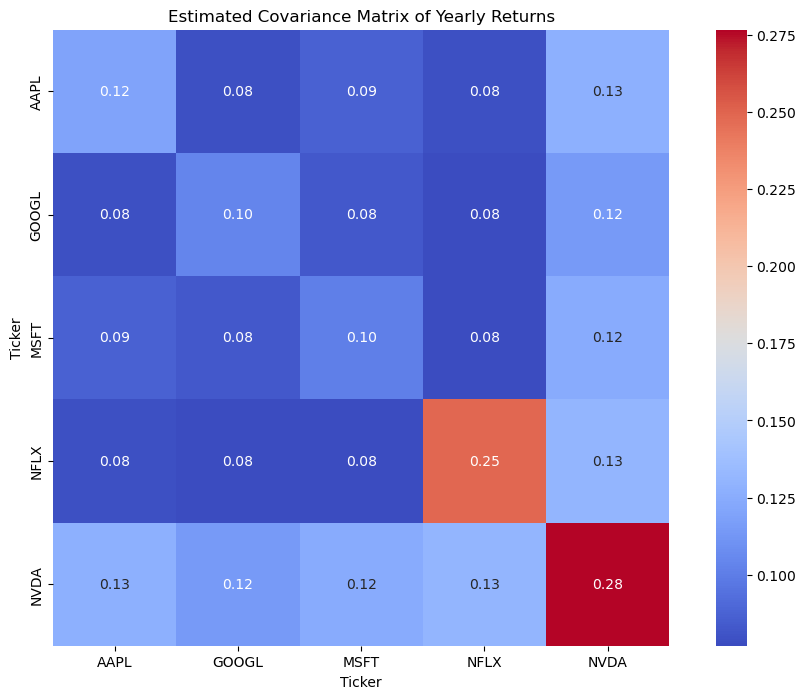

In [5]:
# estimated covariance amtrix of yearly returns
cov_all = log_returns.cov() * 252
plt.figure(figsize=(12, 8))
sns.heatmap(cov_all, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Estimated Covariance Matrix of Yearly Returns')

Text(0.5, 1.0, 'Estimated Covariance Matrix of Yearly Returns')

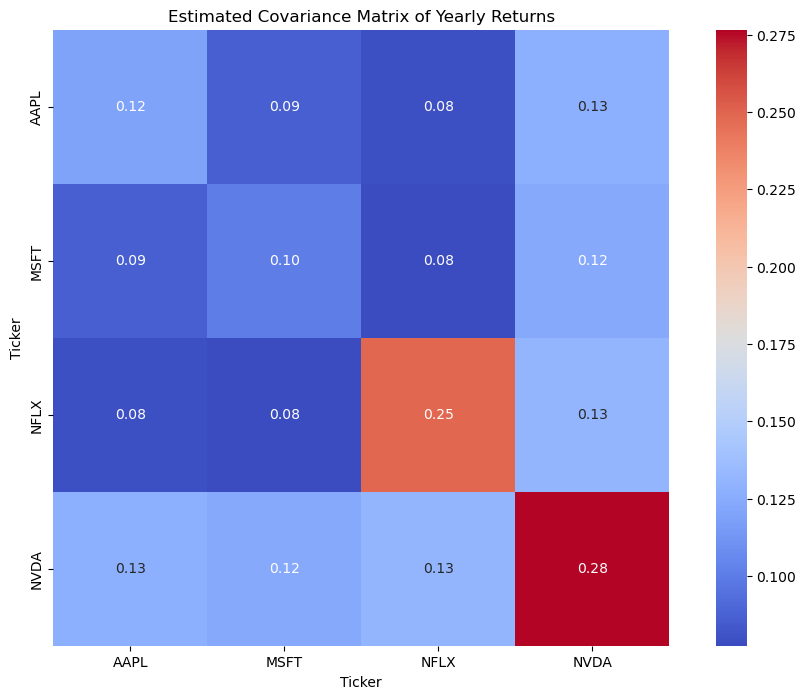

In [6]:
# estimated covariance amtrix of yearly returns
log_returns_invest = log_returns.iloc[:,[0,2,3,4]]
cov_invest = log_returns_invest.cov() * 252
plt.figure(figsize=(12, 8))
sns.heatmap(cov_invest, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Estimated Covariance Matrix of Yearly Returns')

In [7]:
google_return_1 = log_returns.iloc[:251]['GOOGL'].sum()
google_return_2 = log_returns.iloc[251:503]['GOOGL'].sum()
google_return_3 = log_returns.iloc[503:756]['GOOGL'].sum()
google_return_4 = log_returns.iloc[756:]['GOOGL'].sum()

print(google_return_1)
print(google_return_2)
print(google_return_3)
print(google_return_4)


0.23897695913077316
0.25951318963884407
0.5119620804236129
-0.49576547823083394


In [10]:
# optimized portfolio with high risk

# number of assets:
n_assets = len(tickers)-1

# initial guess for weights (equal distribution)
initial_weights = np.array([1/n_assets]*n_assets)

bounds = [(0, 1) for _ in range(n_assets)]

constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
    {'type': 'ineq', 'fun': lambda weights: np.dot(log_returns_invest.iloc[:251,:].sum(axis = 0), weights) - google_return_1},
    {'type': 'ineq', 'fun': lambda weights: np.dot(log_returns_invest.iloc[251:503,:].sum(axis = 0), weights) - google_return_2},
    {'type': 'ineq', 'fun': lambda weights: np.dot(log_returns_invest.iloc[503:756,:].sum(axis = 0), weights) - google_return_3},
    {'type': 'ineq', 'fun': lambda weights: np.dot(log_returns_invest.iloc[756:,:].sum(axis = 0), weights) - google_return_4}
)


def portfolio_volatility(weights):
    portfolio_var = np.dot(weights.T, np.dot(cov_invest, weights))
    return portfolio_var

high_risk_result = minimize(portfolio_volatility,
                             initial_weights, 
                             constraints=constraints,
                             bounds=bounds)

high_risk_wt = high_risk_result.x
print(np.sqrt(high_risk_result.fun))
print(high_risk_wt)

0.34353017525429014
[2.49800181e-16 7.72194687e-01 0.00000000e+00 2.27805313e-01]


In [11]:
# optimized portfolio with low risk

# number of assets:
n_assets = len(tickers)-1

# initial guess for weights (equal distribution)
initial_weights = np.array([1/n_assets]*n_assets)
bounds = [(0, 1) for _ in range(n_assets)]
constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
)


def portfolio_volatility(weights):
    portfolio_var = np.dot(weights.T, np.dot(cov_invest, weights))
    return portfolio_var

low_risk_result = minimize(portfolio_volatility,
                             initial_weights, 
                             constraints=constraints,
                             bounds=bounds)

low_risk_wt = low_risk_result.x
print(np.sqrt(low_risk_result.fun))
print(low_risk_wt)

0.3077530597471568
[2.65461303e-01 6.37724087e-01 9.68146103e-02 5.62700928e-17]


In [12]:
individual_volatilites = np.std(log_returns, axis = 0)*np.sqrt(252)
individual_log_returns = np.sum(log_returns, axis = 0)
# print(individual_log_returns[[0,2,3,4]])
hish_risk_return = np.dot(individual_log_returns[[0,2,3,4]], high_risk_wt)
low_risk_return = np.dot(individual_log_returns[[0,2,3,4]], low_risk_wt)
print(f'Annualized log returns from individual stocks: \n{individual_log_returns}')
print(f'Annualized volatilities from individual stocks: \n{individual_volatilites}')
print(f'High risk portfolio: \n log return: {hish_risk_return} and volatility: {np.sqrt(high_risk_result.fun)}')
print(f'Low risk portfolio: \n log return: {low_risk_return} and volatility: {np.sqrt(low_risk_result.fun)}')

Annualized log returns from individual stocks: 
Ticker
AAPL     1.226647
GOOGL    0.514687
MSFT     0.906471
NFLX     0.096851
NVDA     1.463942
dtype: float64
Annualized volatilities from individual stocks: 
Ticker
AAPL     0.345749
GOOGL    0.321708
MSFT     0.317193
NFLX     0.498424
NVDA     0.525617
dtype: float64
High risk portfolio: 
 log return: 1.0334656461521174 and volatility: 0.34353017525429014
Low risk portfolio: 
 log return: 0.9130820361063064 and volatility: 0.3077530597471568


In [13]:
end_date = dt.datetime(2024, 12, 31); start_date = end_date - dt.timedelta(days=365)
stock_2024 = yf.download(tickers, start=start_date, end=end_date)
log_returns_2024 = np.log(stock_2024['Close']/stock_2024['Close'].shift(1))
log_returns_2024.dropna(inplace = True)
log_returns_2024.head()
individual_log_returns_2024 = log_returns_2024.sum(axis = 0)
individual_volatilites_2024 = np.std(log_returns_2024, axis = 0)*np.sqrt(252)
cov_mat_2024 = 252 * log_returns_2024.iloc[:,[0,2,3,4]].cov()



high_return_2024 = np.dot(high_risk_wt, individual_log_returns_2024[[0,2,3,4]])
high_volatility_2024 = np.dot(high_risk_wt.T, np.dot(cov_mat_2024, high_risk_wt))

low_return_2024 = np.dot(low_risk_wt, individual_log_returns_2024[[0,2,3,4]])
low_volatility_2024 = np.dot(low_risk_wt.T, np.dot(cov_mat_2024, low_risk_wt))

print('2024 Individual Returns: \n----------------------------------------------')
print(f'log returns from individual stocks: \n{individual_log_returns_2024}')
print(f'Volatilities from individual stocks: \n{individual_volatilites_2024}')
print('2024 Portfolio Returns: \n----------------------------------------------')
print(f'High risk portfolio: \n log return: {high_return_2024} and volatility: {np.sqrt(high_volatility_2024)}')
print(f'Low risk portfolio: \n log return: {low_return_2024} and volatility: {np.sqrt(low_volatility_2024)}')




C:\Users\sayak\AppData\Local\Temp\ipykernel_10760\4060282937.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_2024 = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed

2024 Individual Returns: 
----------------------------------------------
log returns from individual stocks: 
Ticker
AAPL     0.311300
GOOGL    0.328663
MSFT     0.143288
NFLX     0.653336
NVDA     1.049140
dtype: float64
Volatilities from individual stocks: 
Ticker
AAPL     0.223082
GOOGL    0.279887
MSFT     0.200381
NFLX     0.292069
NVDA     0.519969
dtype: float64
2024 Portfolio Returns: 
----------------------------------------------
High risk portfolio: 
 log return: 0.3496454744720402 and volatility: 0.23464581484883876
Low risk portfolio: 
 log return: 0.2372685526586682 and volatility: 0.17859304650047397
